# A4 Convolutional Neural Networks

*by Chuck Anderson for [CS545: Machine Learning](https://www.cs.colostate.edu/~anderson/cs545) at Colorado State University*


#### Defining the NeuralNetwork_Convolution Class.

In [1]:
import numpy as np
import torch
import time
import copy
import sys


class NeuralNetwork_Convolutional():
    
    def __init__(self, n_channels_in_image, image_size,
                 n_units_in_conv_layers, kernels_size_and_stride,
                 n_units_in_fc_hidden_layers,
                 classes, use_gpu=False):

        if not isinstance(n_units_in_conv_layers, list):
            raise Exception('n_units_in_conv_layers must be a list')

        if not isinstance(n_units_in_fc_hidden_layers, list):
            raise Exception('n_units_in_fc_hidden_layers must be a list')
        
        if use_gpu and not torch.cuda.is_available():
            print('\nGPU is not available. Running on CPU.\n')
            use_gpu = False

        self.n_channels_in_image = n_channels_in_image
        self.image_size = image_size 
        self.n_units_in_conv_layers = n_units_in_conv_layers
        self.n_units_in_fc_hidden_layers = n_units_in_fc_hidden_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        self.n_outputs = len(classes)
        self.classes = np.array(classes)
        self.use_gpu = use_gpu
        
        self.n_conv_layers = len(self.n_units_in_conv_layers)
        self.n_fc_hidden_layers = len(self.n_units_in_fc_hidden_layers)

        
        self.nnet = torch.nn.Sequential()

        # Adding convolutional layers

        n_units_previous = self.n_channels_in_image
        output_size_previous = self.image_size
        n_layers = 0
        if self.n_conv_layers > 0:

            for (n_units, kernel) in zip(self.n_units_in_conv_layers, self.kernels_size_and_stride):
                n_units_previous, output_size_previous = self._add_conv2d_tanh(n_layers,
                                        n_units_previous, output_size_previous, n_units, kernel)
                n_layers += 1 
                
        #Fully connected layers
        
        self.nnet.add_module('flatten', torch.nn.Flatten())  

        n_inputs = output_size_previous ** 2 * n_units_previous
        if self.n_fc_hidden_layers > 0:
            for n_units in self.n_units_in_fc_hidden_layers:
                n_inputs = self._add_fc_tanh(n_layers, n_inputs, n_units)
                n_layers += 1

        self.nnet.add_module(f'output_{n_layers}', torch.nn.Linear(n_inputs, self.n_outputs))

        # Standardization
        self.Xmeans = None
        self.Xstds = None

        if self.use_gpu:
            self.nnet.cuda()

        self.n_epochs = 0
        self.error_trace = []

    def _add_conv2d_tanh(self, n_layers, n_units_previous, output_size_previous,
                   n_units, kernel_size_and_stride):
        kernel_size, kernel_stride = kernel_size_and_stride
        self.nnet.add_module(f'conv_{n_layers}', torch.nn.Conv2d(n_units_previous, n_units,
                                                                 kernel_size, kernel_stride))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        output_size_previous = (output_size_previous - kernel_size) // kernel_stride + 1
        n_units_previous = n_units                
        return n_units_previous, output_size_previous
    
    def _add_fc_tanh(self, n_layers, n_inputs, n_units):
        self.nnet.add_module(f'linear_{n_layers}', torch.nn.Linear(n_inputs, n_units))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        n_inputs = n_units
        return n_inputs

    def __repr__(self):
        str = f'''{type(self).__name__}(
                            n_channels_in_image={self.n_channels_in_image},
                            image_size={self.image_size},
                            n_units_in_conv_layers={self.n_units_in_conv_layers},
                            kernels_size_and_stride={self.kernels_size_and_stride},
                            n_units_in_fc_hidden_layers={self.n_units_in_fc_hidden_layers},
                            classes={self.classes},
                            use_gpu={self.use_gpu})'''

        str += self.nnet
        if self.n_epochs > 0:
            str += f'\n   Network was trained for {self.n_epochs} epochs that took {self.training_time:.4f} seconds.'
            str += f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
        
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

    def train(self, X, T, n_epochs, learning_rate=0.01):

        start_time = time.time()
        
        self.learning_rate = learning_rate

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        _, T = np.where(T == self.classes)  

        self._setup_standardize(X, T)
        X = self._standardizeX(X)

        X = torch.tensor(X)
    
        T = torch.tensor(T.reshape(-1))
        if self.use_gpu:
            X = X.cuda()
            T = T.cuda()

        loss_F = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.nnet.parameters(), lr=learning_rate)

        for epoch in range(n_epochs):
            optimizer.zero_grad()
        
            Y = self.nnet(X)
            error = loss_F(Y, T)
            self.error_trace.append(error)
            error.backward()
            optimizer.step()
            
        if epoch % 50 == 0:
            print(f'Epoch {epoch} error {error}')
        
        end_time = time.time()
        self.training_time = end_time - start_time
 
            
    def get_error_trace(self):
        return self.error_trace
    
    def _softmax(self, Y):
        mx = Y.max()
        expY = np.exp(Y - mx)
        denom = expY.sum(axis=1).reshape((-1, 1)) + sys.float_info.epsilon
        return expY / denom
    
    def use(self, X):
        self.nnet.eval()  
        X = self._standardizeX(X)
        X = torch.tensor(X)
        if self.use_gpu:
            X = X.cuda()

        Y = self.nnet(X)

        if self.use_gpu:
            Y = Y.cpu()
        Y = Y.detach().numpy()
        Yclasses = self.classes[Y.argmax(axis=1)].reshape((-1, 1))

        return Yclasses, self._softmax(Y)

## Simple Example with Squares and Diamonds

Repeating the example from lecture notes.

In [2]:
import matplotlib.pyplot as plt

In [3]:
def make_images(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
            T = np.ones((nEach * 2, 1))
            T[nEach:] = 2
    return images.astype(np.float32), T.astype(np.int)

Xtrain, Ttrain = make_images(500)
Xtest, Ttest = make_images(10)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 1, 20, 20), (1000, 1), (20, 1, 20, 20), (20, 1))

In [4]:
Xtrain.shape[2]

20

In [5]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5], 
                                   kernels_size_and_stride=[[5, 2]], 
                                   n_units_in_fc_hidden_layers=[2], 
                                   classes=[1, 2],
                                   use_gpu=False)

nnet.train(Xtrain, Ttrain, 500, learning_rate=0.01)

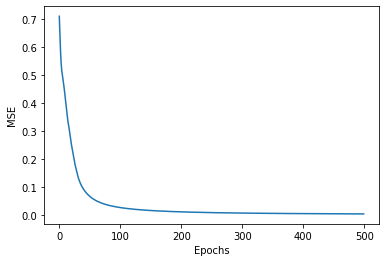

In [6]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

In [7]:
Yclasses, Y = nnet.use(Xtest)

print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.', end='')


20 out of 20 test samples correctly classified.

Let's see what the output of the convolutional layer produces, and the weight matrices of each unit that produce those output images.   Here are functions, `show_layer_output` and `show_layer_weights` that will do this for us.

In [9]:
import matplotlib.pyplot as plt

def show_layer_output(nnet, X_sample, layer):
    outputs = []
    reg = nnet.nnet[layer * 2].register_forward_hook(
        lambda self, i, o: outputs.append(o))
    nnet.use(X_sample)
    reg.remove()
    output = outputs[0]

    n_units = output.shape[1]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit+1)
        plt.imshow(output[0, unit, :, :].detach(),cmap='binary')
        plt.axis('off')
    return output

def show_layer_weights(nnet, layer):
    W = nnet.nnet[layer*2].weight.detach()
    n_units = W.shape[0]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit + 1)
        plt.imshow(W[unit, 0, :, :], cmap='binary')
        plt.axis('off')
    return W

(-0.5, 19.5, 19.5, -0.5)

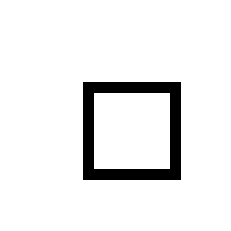

In [10]:
X_sample = Xtest[0:1, :, :, :]
plt.imshow(X_sample[0, 0, :, :], cmap='binary')
plt.axis('off')

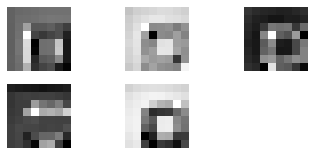

In [11]:
show_layer_output(nnet, X_sample, 0);

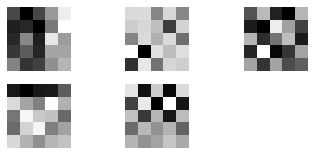

In [12]:
show_layer_weights(nnet, 0);

## MNIST Digits

Investigate the application of your code to the classification of MNIST digits, which you may download from [this site](http://deeplearning.net/tutorial/gettingstarted.html).

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [14]:
Xtrain = train_set[0]
Ttrain = train_set[1]
Xtest = test_set[0]
Ttest = test_set[1]
Xtrain = Xtrain.reshape(-1, 1, 28, 28)
Xtest = Xtest.reshape(-1, 1, 28, 28)
Ttest.reshape(-1)
Xtrain.shape, Ttrain.shape

((50000, 1, 28, 28), (50000,))

In [15]:
a = Xtrain[0, :].reshape(28, 28)
a.shape

(28, 28)

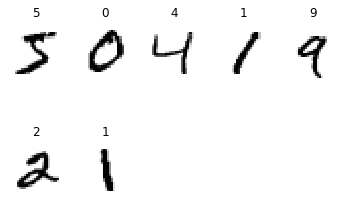

In [16]:
for i in range(7):
    plt.subplot(2, 5, i + 1)
    plt.imshow(Xtrain[i, :].reshape(28, 28), cmap='binary')
    plt.title(Ttrain[i])
    plt.axis('off');

### Running the Network

In [6]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[6 , 7],
                                   kernels_size_and_stride=[[4, 2]], 
                                   n_units_in_fc_hidden_layers=[5], 
                                   classes=np.unique(Ttrain),
                                   use_gpu=True)


GPU is not available. Running on CPU.



In [7]:
nnet.train(Xtrain, Ttrain, 300, learning_rate=0.01)

Testing   : 47745 out of 50000 (95.5%) samples correctly classified.
Testing   :  9382 out of 10000 (93.8%) samples correctly classified.


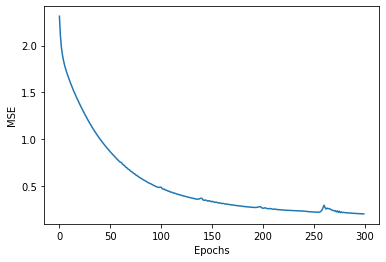

In [11]:
for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    n_correct = np.sum(T == Y)
    n = T.shape[0]
    print(f'{name:10}: {n_correct:5d} out of {n:5d} ({n_correct / n * 100:.1f}%) samples correctly classified.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

### Diffirent Kernel size and Strides

In [25]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[6 , 7],
                                   kernels_size_and_stride=[[5, 5]], 
                                   n_units_in_fc_hidden_layers=[5], 
                                   classes=np.unique(Ttrain),
                                   use_gpu=True)


GPU is not available. Running on CPU.



In [26]:
nnet.train(Xtrain, Ttrain, 300, learning_rate=0.01)

Testing   : 44995 out of 50000 (90.0%) samples correctly classified.
Testing   :  9002 out of 10000 (90.0%) samples correctly classified.


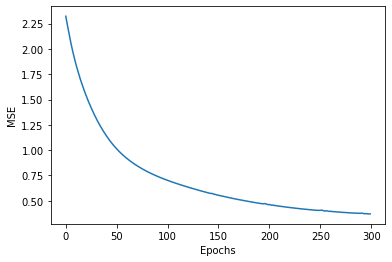

In [27]:
for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    n_correct = np.sum(T == Y)
    n = T.shape[0]
    print(f'{name:10}: {n_correct:5d} out of {n:5d} ({n_correct / n * 100:.1f}%) samples correctly classified.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

#### Discussion

If the strides are high then the accuracy of classifying images drops proportional to the strides. It can be said the same with the kernel size, although it doesn't affect the image as significantly as the strides do. This is so probably because of the type of images we used.

### Different no. of Layers and Units

In [30]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[20 , 10 , 11],
                                   kernels_size_and_stride=[[6, 1]], 
                                   n_units_in_fc_hidden_layers=[40 , 30], 
                                   classes=np.unique(Ttrain),
                                   use_gpu=True)


GPU is not available. Running on CPU.



In [31]:
nnet.train(Xtrain, Ttrain, 300, learning_rate=0.01)

Testing   : 49947 out of 50000 (99.9%) samples correctly classified.
Testing   :  9685 out of 10000 (96.9%) samples correctly classified.


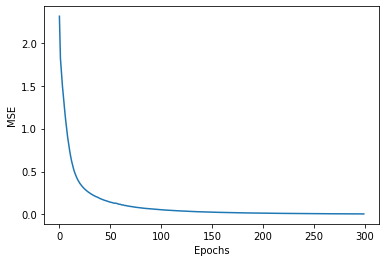

In [32]:
for name, X, T in (('Training', Xtrain, Ttrain),
                   ('Testing', Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    n_correct = np.sum(T == Y)
    n = T.shape[0]
    print(f'{name:10}: {n_correct:5d} out of {n:5d} ({n_correct / n * 100:.1f}%) samples correctly classified.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

#### Discussion

If we increase the number of convolutional and hidden layers with more number of weights then the neural network perform significantly better with 99.9% correctly Tested images and ~97% correctly Trained images. 

For the network to run smoothly the number of weights of the layers need to be in three digits.

#### Different Learning rates and Epochs

In [20]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[6 , 7],
                                   kernels_size_and_stride=[[5, 1]], 
                                   n_units_in_fc_hidden_layers=[5], 
                                   classes=np.unique(Ttrain),
                                   use_gpu=True)


GPU is not available. Running on CPU.



In [23]:
nnet.train(Xtrain, Ttrain, 200, learning_rate=0.05)

Testing   : 47715 out of 50000 (95.4%) samples correctly classified.
Testing   :  9365 out of 10000 (93.7%) samples correctly classified.


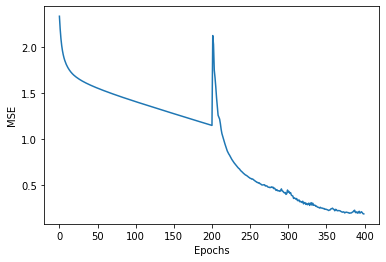

In [24]:
for X, T in ((Xtrain, Ttrain),
                   (Xtest, Ttest)):
    Y, _ = nnet.use(X)
    T = T.reshape((-1, 1))
    n_correct = np.sum(T == Y)
    n = T.shape[0]
    print(f'{name:10}: {n_correct:5d} out of {n:5d} ({n_correct / n * 100:.1f}%) samples correctly classified.')
    
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

#### Discussion

The learning rates if are inbetween 0.01 and 0.08 the neural network's classification is well above 90% but if to either increase or decrease outside the upper bound and lower bound respectively then the accuracy drops quite significantly to well below 50%

# Grading

Download [A4grader.zip](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.zip) and extract A4grader.py from it. 

In [17]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Tamidapati-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetwork_Convolutional can learn to classify a small 
subset of hand_drawn 0, 1, and 2 digits.

import numpy as np
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
Xtest = test_set[0]
traini = [3,  10,  13,  25,  28,  55,  69,  71, 101, 126, 2,   5,  14,  29,  31,  37,  39,  40,  46,  57, 1,  35,  38,  43,  47,  72,  77,  82, 106, 119]
testi = [136, 148, 157, 183, 188, 192, 194, 215, 246, 269,  74,  89,  94, 96, 107, 135, 137, 143, 145, 154, 147, 149, 172, 174, 186, 199, 208, 221, 222, 225]
Xtrain = test_set[0][traini, :].reshape(-1, 1, 28, 28)
Ttrain = test_set[1][traini].reshape(-1, 1)
Xtest = test_set[0][testi, :].resha